In [10]:
from datasets.get_datasets import *
from revision import *
from boostsrl import boostsrl
import random

## Parameters

In [11]:
target = 'athleteplaysforteam'
test_size = 0.3
small_train_size = 0.3
validation_size = 0.2
revision_threshold = 0.95
max_revision_iterations = 10

## Dataset

In [12]:
[facts, pos, neg] = get_nell_dataset(target)

## Background  configuration

In [13]:
bk = ['athleteledsportsteam(+athlete,+sportsteam).',
      'athleteledsportsteam(+athlete,-sportsteam).',
      'athleteledsportsteam(-athlete,+sportsteam).',
      'athleteplaysforteam(+athlete,+sportsteam).',
      'athleteplaysforteam(+athlete,-sportsteam).',
      'athleteplaysforteam(-athlete,+sportsteam).',
      'athleteplaysinleague(+athlete,+sportsleague).',
      'athleteplaysinleague(+athlete,-sportsleague).',
      'athleteplaysinleague(-athlete,+sportsleague).',
      'athleteplayssport(+athlete,+sport).',
      'athleteplayssport(+athlete,-sport).',
      'athleteplayssport(-athlete,+sport).',
      'teamalsoknownas(+sportsteam,+sportsteam).',
      'teamalsoknownas(+sportsteam,-sportsteam).',
      'teamalsoknownas(-sportsteam,+sportsteam).',
      'teamplaysagainstteam(+sportsteam,+sportsteam).',
      'teamplaysagainstteam(+sportsteam,-sportsteam).',
      'teamplaysagainstteam(-sportsteam,+sportsteam).',
      'teamplaysinleague(+sportsteam,+sportsleague).',
      'teamplaysinleague(+sportsteam,-sportsleague).',
      'teamplaysinleague(-sportsteam,+sportsleague).',
      'teamplayssport(+sportsteam,+sport).',
      'teamplayssport(+sportsteam,-sport).',
      'teamplayssport(-sportsteam,+sport).']

background = boostsrl.modes(bk, [target], useStdLogicVariables=False, treeDepth=8, nodeSize=3, numOfClauses=8)

## Sampling examples

In [14]:
# shuffle all examples
random.shuffle(pos)
random.shuffle(neg)

# separate train and test
test_pos = pos[:int(test_size*len(pos))]
test_neg = neg[:int(test_size*len(neg))]
train_pos = pos[int(test_size*len(pos)):]
train_neg = neg[int(test_size*len(neg)):]

# learn from scratch in a small dataset
s_train_pos = train_pos[:int(small_train_size*len(train_pos))]
s_train_neg = train_neg[:int(small_train_size*len(train_neg))]

# shuffle all train examples
random.shuffle(train_pos)
random.shuffle(train_neg)

# train set used in revision and validation set
r_train_pos = train_pos[int(validation_size*len(train_pos)):]
r_train_neg = train_neg[int(validation_size*len(train_neg)):]
validation_pos = train_pos[:int(validation_size*len(train_pos))]
validation_neg = train_neg[:int(validation_size*len(train_neg))]

print('Total examples')
print('Positive examples: %s' % len(pos))
print('Negative examples: %s' % len(neg))
print('\n')
print('Train and test sets from total')
print('Train Positive examples: %s' % len(train_pos))
print('Train Negative examples: %s' % len(train_neg))
print('Test Positive examples: %s' % len(test_pos))
print('Test Negative examples: %s' % len(test_neg))
print('\n')
print('Small dataset')
print('Train Positive examples: %s' % len(s_train_pos))
print('Train Negative examples: %s' % len(s_train_neg))
print('\n')
print('Revision theory train dataset and validation')
print('Train Positive examples: %s' % len(r_train_pos))
print('Train Negative examples: %s' % len(r_train_neg))
print('Validation Positive examples: %s' % len(validation_pos))
print('Validation Negative examples: %s' % len(validation_neg))

Total examples
Positive examples: 1458
Negative examples: 1458


Train and test sets from total
Train Positive examples: 1021
Train Negative examples: 1021
Test Positive examples: 437
Test Negative examples: 437


Small dataset
Train Positive examples: 306
Train Negative examples: 306


Revision theory train dataset and validation
Train Positive examples: 817
Train Negative examples: 817
Validation Positive examples: 204
Validation Negative examples: 204


## Learning from small dataset

WILL-Produced Tree:
% FOR athleteplaysforteam(A, B):
%   if ( athleteledsportsteam(A, B) )
%   then return 0.8581489350995126;  // std dev = 0,000, 63,000 (wgt'ed) examples reached here.  /* #pos=63 */
%   else if ( athleteledsportsteam(A, C) )
%   | then return 0.06350607795665476;  // std dev = 0,404, 112,000 (wgt'ed) examples reached here.  /* #neg=89 #pos=23 */
%   | else if ( teamplaysagainstteam(D, B), teamalsoknownas(E, D), teamplaysagainstteam(B, E) )
%   | | then if ( teamalsoknownas(D, E), teamalsoknownas(D, F), teamalsoknownas(E, F) )
%   | | | then return 0.6255907955646293;  // std dev = 0,422, 86,000 (wgt'ed) examples reached here.  /* #neg=20 #pos=66 */
%   | | | else if ( teamalsoknownas(D, G) )
%   | | | | then if ( athleteledsportsteam(H, B), athleteplayssport(A, I), athleteplayssport(H, I) )
%   | | | | | then return 0.6914822684328457;  // std dev = 1,581, 18,000 (wgt'ed) examples reached here.  /* #neg=3 #pos=15 */
%   | | | | | else return 0.20189893509951237;  //

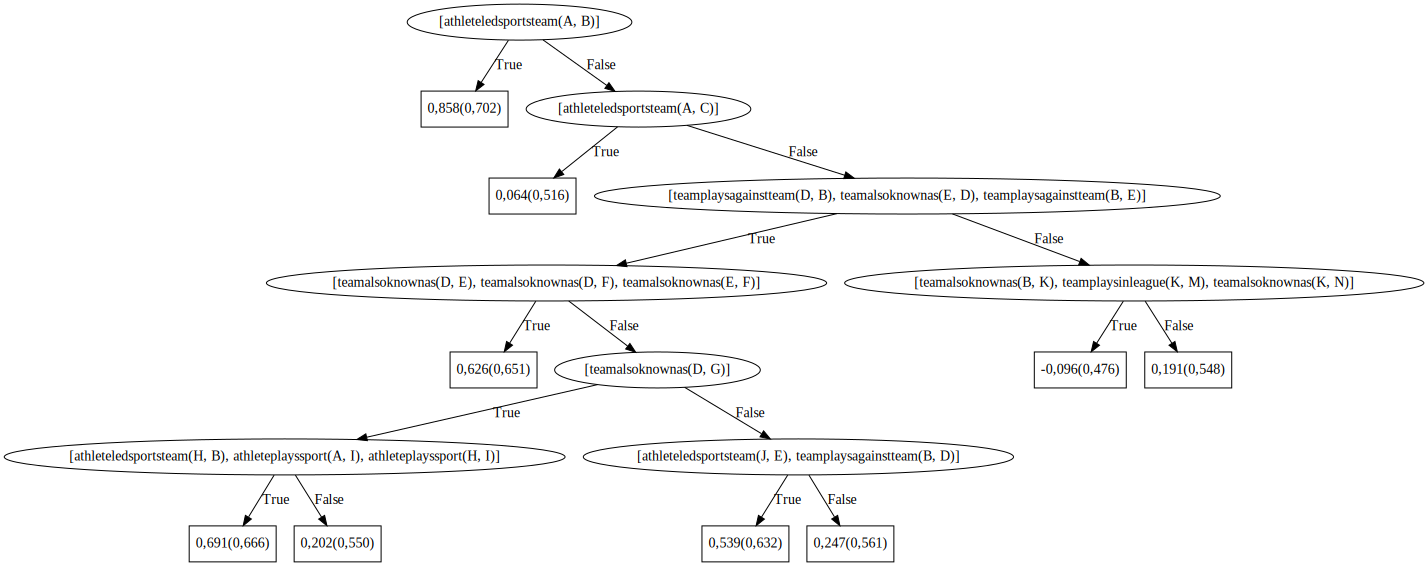

In [15]:
delete_model_files()
model = boostsrl.train(background, s_train_pos, s_train_neg, facts)
learning_time = model.traintime()
will = model.get_will_produced_tree()
structured = model.get_structured_tree().copy()
results = boostsrl.test(model, test_pos, test_neg, facts)
inference_time = results.testtime()
t_results = results.summarize_results()
print('WILL-Produced Tree:')
print_will_produced_tree(will)
print('\n')
print('Results:')
print(t_results)
print('\n')
print('Total learning time: %s seconds' % learning_time)
print('Total inference time: %s seconds' % inference_time)
print('AUC ROC: %s' % t_results['AUC ROC'])
print('\n')
print('Tree:')
model.tree(0, target, image=True)

## Learning from complete dataset

WILL-Produced Tree:
% FOR athleteplaysforteam(A, B):
%   if ( athleteledsportsteam(A, B) )
%   then return 0.8581489350995092;  // std dev = 1,08e-06, 197,000 (wgt'ed) examples reached here.  /* #pos=197 */
%   else if ( athleteledsportsteam(A, C), teamplaysagainstteam(C, D) )
%   | then if ( teamplaysagainstteam(B, D), athleteplaysinleague(A, E), teamplaysinleague(B, E) )
%   | | then return 0.48672036367094135;  // std dev = 0,483, 70,000 (wgt'ed) examples reached here.  /* #neg=26 #pos=44 */
%   | | else return -0.032696135323022846;  // std dev = 0,312, 284,000 (wgt'ed) examples reached here.  /* #neg=253 #pos=31 */
%   | else if ( athleteledsportsteam(F, B), teamplaysinleague(B, G), athleteplaysinleague(A, G) )
%   | | then return 0.6966906017661759;  // std dev = 0,368, 192,000 (wgt'ed) examples reached here.  /* #neg=31 #pos=161 */
%   | | else if ( athleteplaysinleague(A, H), teamplaysinleague(I, H) )
%   | | | then return 0.04819418396828989;  // std dev = 0,392, 221,000 (wgt'

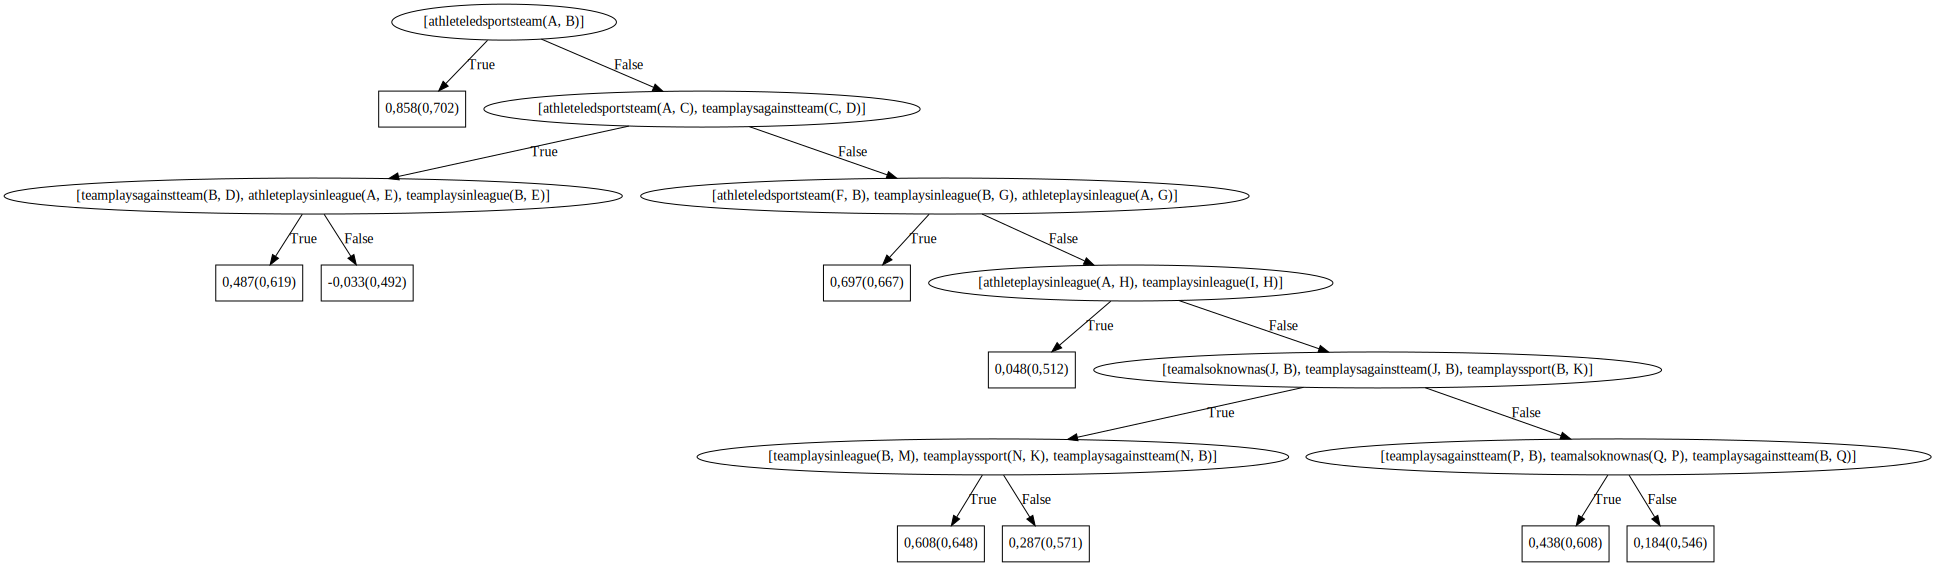

In [16]:
delete_model_files()
model = boostsrl.train(background, train_pos, train_neg, facts)
learning_time = model.traintime()
will = model.get_will_produced_tree()
#structured = model.get_structured_tree().copy()
results = boostsrl.test(model, test_pos, test_neg, facts)
inference_time = results.testtime()
t_results = results.summarize_results()
print('WILL-Produced Tree:')
print_will_produced_tree(will)
print('\n')
print('Results:')
print(t_results)
print('\n')
print('Total learning time: %s seconds' % learning_time)
print('Total inference time: %s seconds' % inference_time)
print('AUC ROC: %s' % t_results['AUC ROC'])
print('\n')
print('Tree:')
model.tree(0, target, image=True)

## Theory Revision

Performing parameter learning
******************************************
WILL-Produced Tree:
% FOR athleteplaysforteam(A, B):
%   if ( athleteledsportsteam(A, B) )
%   then return 0.8581489350995097;  // std dev = 9,83e-07, 157,000 (wgt'ed) examples reached here.  /* #pos=157 */
%   else if ( athleteledsportsteam(A, C) )
%   | then return 0.0724346493852272;  // std dev = 7,036, 294,000 (wgt'ed) examples reached here.  /* #neg=231 #pos=63 */
%   | else if ( teamplaysagainstteam(D, B), teamalsoknownas(E, D), teamplaysagainstteam(B, E) )
%   | | then if ( teamalsoknownas(D, E), teamalsoknownas(D, F), teamalsoknownas(E, F) )
%   | | | then return 0.5511721909134626;  // std dev = 6,763, 215,000 (wgt'ed) examples reached here.  /* #neg=66 #pos=149 */
%   | | | else if ( teamalsoknownas(D, G) )
%   | | | | then if ( athleteledsportsteam(H, B), athleteplayssport(A, I), athleteplayssport(H, I) )
%   | | | | | then return 0.7331489350995126;  // std dev = 2,646, 64,000 (wgt'ed) examples reache

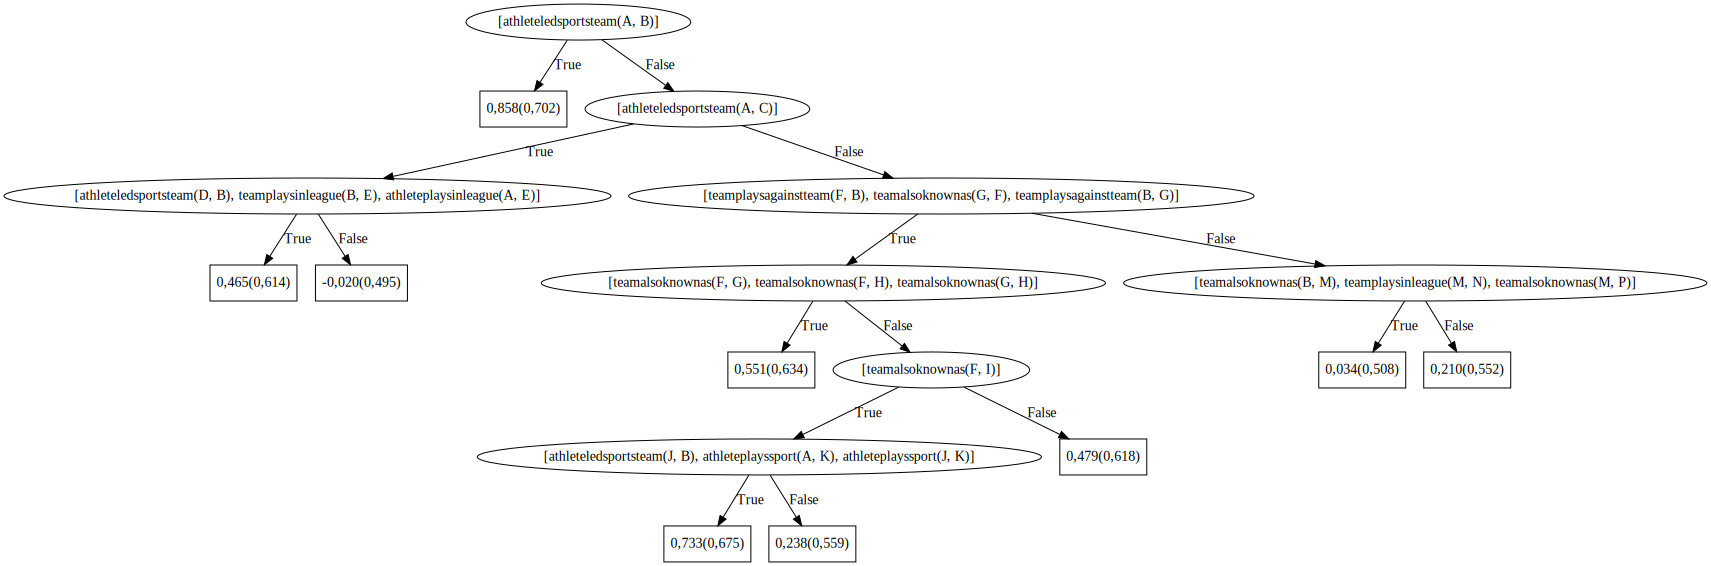

In [17]:
total_revision_time = 0
best_aucroc = 0
best_structured = None

print('Performing parameter learning')
print('******************************************')
delete_model_files()
model = boostsrl.train(background, r_train_pos, r_train_neg, facts, refine=get_refine_file(structured))
learning_time = model.traintime()
will = model.get_will_produced_tree()
structured = model.get_structured_tree().copy()
results = boostsrl.test(model, validation_pos, validation_neg, facts)
inference_time = results.testtime()
t_results = results.summarize_results()
total_revision_time += learning_time + inference_time
print('WILL-Produced Tree:')
print_will_produced_tree(will)
print('\n')
print('Results:')
print(t_results)
print('\n')
print('Total learning time: %s seconds' % learning_time)
print('Total inference time: %s seconds' % inference_time)
print('AUC ROC: %s' % t_results['AUC ROC'])
print('\n')
#print('Tree:')
#model.tree(0, target, image=True)

best_aucroc = t_results['AUC ROC']
best_structured = structured.copy()
save_model_files()

for i in range(max_revision_iterations):
    print('Refining iteration %s' % str(i+1))
    print('******************************************')
    found_better = False
    for candidate in get_cantidates(best_structured, revision_threshold):
        print('Refining node candidate')
        print('******************************************')
        delete_model_files()
        model = boostsrl.train(background, r_train_pos, r_train_neg, facts, refine=candidate)
        learning_time = model.traintime()
        will = model.get_will_produced_tree()
        results = boostsrl.test(model, validation_pos, validation_neg, facts)
        inference_time = results.testtime()
        t_results = results.summarize_results()
        total_revision_time += learning_time + inference_time
        print('WILL-Produced Tree:')
        print_will_produced_tree(will)
        print('\n')
        print('Results:')
        print(t_results)
        print('\n')
        print('Total learning time: %s seconds' % learning_time)
        print('Total inference time: %s seconds' % inference_time)
        print('AUC ROC: %s' % t_results['AUC ROC'])
        print('\n')
        #print('Tree:')
        #model.tree(0, target, image=True)
        print('******************************************')

        if t_results['AUC ROC'] > best_aucroc:
            found_better = True
            best_aucroc = t_results['AUC ROC']
            best_structured = model.get_structured_tree().copy()
            save_model_files()
    print('Best Tree AUC ROC so far: %s' % best_aucroc)
    print('******************************************\n')
    if found_better == False:
        break

print('******************************************')
delete_model_files()
get_saved_model_files()
delete_test_files()
print('Total revision time: %s' % total_revision_time)
print('Best validation AUC ROC: %s' % best_aucroc)
will = model.get_will_produced_tree()
results = boostsrl.test(model, test_pos, test_neg, facts)
inference_time = results.testtime()
t_results = results.summarize_results()
print('WILL-Produced Tree:')
print_will_produced_tree(will)
print('\n')
print('Results:')
print(t_results)
print('\n')
print('Total inference time: %s seconds' % inference_time)
print('AUC ROC: %s' % t_results['AUC ROC'])
print('\n')
print('Tree:')
model.tree(0, target, image=True)